<a href="https://colab.research.google.com/github/tianshapojun/Saimo/blob/main/macro_traffic_data_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install osmnx
import osmnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 13.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. 

RuntimeError: ignored

In [ ]:
import numpy as np
import pandas as pd
import scipy
import osmnx as ox
import networkx as nx 
from tqdm import *
import time
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import haversine_distances
import sklearn

#Highway地图下载

In [ ]:
ox.config(use_cache=True, log_console=True)
cf = '["highway"~"motorway|motorway_link"]'
G = ox.graph_from_bbox(34.3316661,33.8583149,-118.1607953,-118.6669434, simplify=True, custom_filter=cf)
print(ox.graph_to_gdfs(G, nodes=False)['highway'].value_counts())
ox.save_graph_xml(G, filepath='./Macro_Data/train.osm')

#读取station数据，地图匹配

In [ ]:
# 读取station数据，构建DataFrame表：ID,Latitude,Longitude
# station有脏数据
data = []
with open('/content/gdrive/MyDrive/Data/TrafficFlow/Macro_Data/d07_text_meta_2022_07_15.txt', 'r') as file1:
    for line in file1:
        data_line = line.strip("\n").split()
        data.append(data_line)
try:
    id_1,id_2,id_3,id_4 = data[0].index('ID'),data[0].index('Latitude'),data[0].index('Longitude'),data[0].index('Dir')
except:
    print('Data Error')
data_ini = []
for i in range(1,len(data)):
    try: 
        data_ini.append([int(data[i][id_1]),float(data[i][id_2]),float(data[i][id_3]),str(data[i][id_4])])
    except:
        continue
data_ini = pd.DataFrame(data_ini,columns=['Station','Latitude','Longitude','Direction'])
print('Initial #stations',data_ini.shape[0])
#确保station唯一
data_ini.drop_duplicates(subset=['Station'],inplace = True)
print('Modified #stations',data_ini.shape[0])

Initial #stations 4681
Modified #stations 4681


In [ ]:
G = ox.graph_from_xml('/content/gdrive/MyDrive/Data/TrafficFlow/Macro_Data/train.osm')
G = G.to_undirected()
lat_set = [d['y'] for n, d in G.nodes(data=True)]
lon_set = [d['x'] for n, d in G.nodes(data=True)]
 
# 获得所选区域的经纬度范围
maxLat = max(lat_set)
maxLon = max(lon_set)
minLat = min(lat_set)
minLon = min(lon_set)
# 输出所选区域的经纬度范围
print('Bounds:' + '\n' + 'minLat: ' + str(minLat) + '\n' + 'maxLat: ' + str(maxLat) + '\n' + 
'minLon: ' + str(minLon) + '\n' + 'maxLon: ' + str(maxLon) )

Bounds:
minLat: 33.8583276
maxLat: 34.3316661
minLon: -118.666014
maxLon: -118.1607953


In [ ]:
def station2node(G,df,minLat,maxLat,minLon,maxLon,rng):
  id_sat = 0
  stat_list = []
  nodes = ox.utils_graph.graph_to_gdfs(G, edges=False, node_geometry=False)[["x", "y"]]
  nodes_rad = np.deg2rad(nodes[["y", "x"]])
  tree = sklearn.neighbors.BallTree(nodes_rad, metric="haversine")
  for i in range(df.shape[0]):
    if minLat <= df.iloc[i,1] <= maxLat and minLon <= df.iloc[i,2] <= maxLon:
      id_sat += 1
      point_rad = np.deg2rad(np.array([df.iloc[i,1],df.iloc[i,2]]).reshape(1,2))
      pos,dist = tree.query_radius(point_rad, r=rng/6371000,return_distance=True)
      dist = dist[0] * 6371000  # convert radians -> meters
      dist = dist.tolist()
      nn = nodes.index[pos[0]]
      nn = nn.tolist()
      if len(dist)>0:
        stat_list.append([df.iloc[i,0],df.iloc[i,1],df.iloc[i,2],df.iloc[i,3],nn,dist])
  return id_sat,stat_list

In [ ]:
rng = 200
id_sat,stat_list = station2node(G,data_ini,minLat,maxLat,minLon,maxLon,rng)
id_set = []
for i in range(len(stat_list)):
  id_set = id_set + stat_list[i][4]
id_set = list(set(id_set))

In [ ]:
#stat_list:station,Latitude,Longitude,Direction,node_ID,dis
#rng = 200
#stat_list = []
#id_sat = 0
#for i in range(100):
#for i in range(data_ini.shape[0]):
    #if minLat <= data_ini.iloc[i,1] <= maxLat and minLon <= data_ini.iloc[i,2] <= maxLon:
        #id_sat += 1
        #nod_id,dis = ox.nearest_nodes(G, data_ini.iloc[i,2], data_ini.iloc[i,1],return_dist=True)
        #if dis < rng:
            #stat_list.append([data_ini.iloc[i,0],data_ini.iloc[i,1],data_ini.iloc[i,2],data_ini.iloc[i,3],nod_id,dis,i])
#id_set = list(set([i[4] for i in stat_list]))

In [ ]:
id_dic = {}
for i in range(len(stat_list)):
  for j in range(len(stat_list[i][4])):
    id_dic[stat_list[i][4][j]]=id_dic.get(stat_list[i][4][j],[])+[stat_list[i][0:4]+[stat_list[i][5][j]]]

In [ ]:
print('#Total stations:',id_sat)
print('#Matched stations:',len(stat_list))
print('Percentage of match:',str(int(10000*len(stat_list)/id_sat)/100)+'%')
print('#Matched nodes:',len(id_set))

#Total stations: 2160
#Matched stations: 1922
Percentage of match: 88.98%
#Matched nodes: 1580


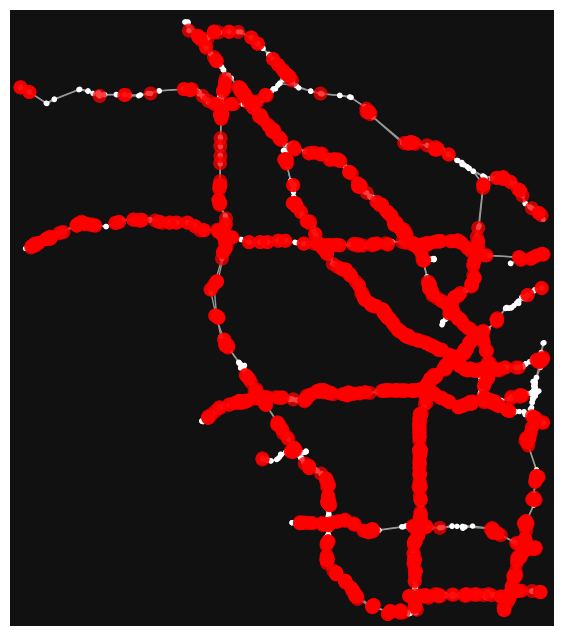

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
ox.plot_graph_routes(G, [[i] for i in id_set])

#距离矩阵

In [ ]:
#路径距离矩阵
dis_mat = np.zeros([len(id_set),len(id_set)])
for i in tqdm(range(len(id_set)),desc='Proceeding...',ncols=100):
    length = nx.single_source_dijkstra_path_length(G,id_set[i],weight='length')
    for j in range(i+1,len(id_set)):
        dis_mat[i][j] = length[id_set[j]]
        dis_mat[j][i] = dis_mat[i][j]

Proceeding...:   9%|███▊                                         | 135/1580 [00:11<01:57, 12.25it/s]


KeyboardInterrupt: ignored

In [ ]:
#球面距离矩阵lat,lon
node_set = [[n,d['y']*np.pi/180,d['x']*np.pi/180] for n, d in G.nodes(data=True)]
node_dic = {}
for i in range(len(node_set)):
    node_dic[node_set[i][0]]=node_dic.get(node_set[i][0],[])+node_set[i][1:3]
#sklearn.metrics.pairwise.haversine_distances()
r_dis_mat = np.zeros([len(id_set),len(id_set)])
for i in tqdm(range(len(id_set)),desc='Proceeding...',ncols=100):
    for j in range(i+1,len(id_set)):
        r_dis_mat[i][j] = haversine_distances(np.array(node_dic[id_set[i]]).reshape(-1,2),np.array(node_dic[id_set[j]]).reshape(-1,2))[0][0]*6371000
        r_dis_mat[j][i] = r_dis_mat[i][j]

Proceeding...: 100%|████████████████████████████████████████████| 1580/1580 [03:23<00:00,  7.76it/s]


In [ ]:
#存储
#dis_mat.dump('/content/gdrive/MyDrive/Data/TrafficFlow/Macro_Data/dis_mat.dat')
#r_dis_mat.dump('/content/gdrive/MyDrive/Data/TrafficFlow/Macro_Data/r_dis_mat.dat')
#np.save('/content/gdrive/MyDrive/Data/TrafficFlow/Macro_Data/id_set.npy',np.array(id_set)) 
#读取
dis_mat = np.load('/content/gdrive/MyDrive/Data/TrafficFlow/Macro_Data/dis_mat.dat',allow_pickle=True)
r_dis_mat = np.load('/content/gdrive/MyDrive/Data/TrafficFlow/Macro_Data/r_dis_mat.dat',allow_pickle=True)
id_set = np.load('/content/gdrive/MyDrive/Data/TrafficFlow/Macro_Data/id_set.npy')
id_set = id_set.tolist()

In [ ]:
print(dis_mat.shape)
print(r_dis_mat.shape)
print(len(id_set))

(1580, 1580)
(1580, 1580)
1580


In [ ]:
temp = []
for i in range(dis_mat.shape[0]):
  for j in range(i+1,dis_mat.shape[0]):
    temp.append(dis_mat[i,j])

80502.93500000003


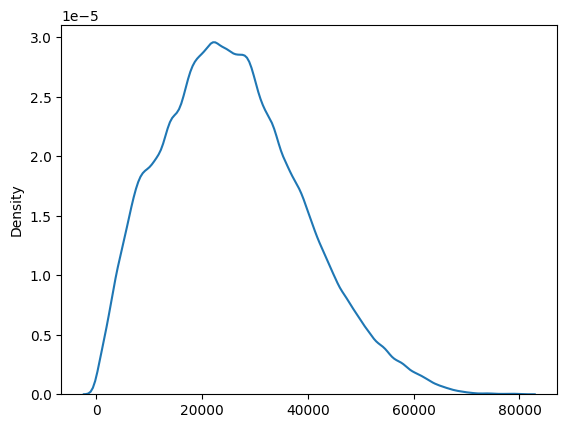

In [ ]:
import seaborn as sns
print(max(temp))
sns.kdeplot(temp)
plt.show()

# 根据距离矩阵，挑选node

In [ ]:
max_element = dis_mat.max()
for i in range(dis_mat.shape[0]):
  dis_mat[i,i] = max_element
max_element = r_dis_mat.max()
for i in range(r_dis_mat.shape[0]):
  r_dis_mat[i,i] = max_element

In [ ]:
#删除两点路径距离<rng的点
rng = 3500
while dis_mat.min() < rng:
  row_index = int(np.argmin(dis_mat) / dis_mat.shape[1])
  col_index = np.argmin(dis_mat) % dis_mat.shape[1]
  temp = row_index
  del id_set[temp]
  dis_mat = np.delete(dis_mat,temp,0)
  dis_mat = np.delete(dis_mat,temp,1)
  r_dis_mat = np.delete(r_dis_mat,temp,0)
  r_dis_mat = np.delete(r_dis_mat,temp,1)

In [ ]:
print(dis_mat.shape)
print(r_dis_mat.shape)
print(len(id_set))

(114, 114)
(114, 114)
114


In [ ]:
#删除两点球面距离<rng的点
rng = 1000
while r_dis_mat.min() < rng:
  row_index = int(np.argmin(r_dis_mat) / r_dis_mat.shape[1])
  col_index = np.argmin(r_dis_mat) % r_dis_mat.shape[1]
  temp = row_index
  del id_set[temp]
  dis_mat = np.delete(dis_mat,temp,0)
  dis_mat = np.delete(dis_mat,temp,1)
  r_dis_mat = np.delete(r_dis_mat,temp,0)
  r_dis_mat = np.delete(r_dis_mat,temp,1)

In [ ]:
print(dis_mat.shape)
print(r_dis_mat.shape)
print(len(id_set))

(95, 95)
(95, 95)
95


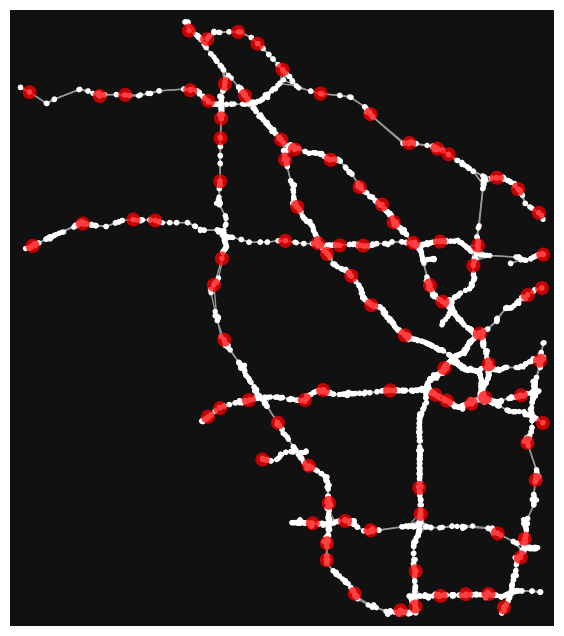

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
ox.plot_graph_routes(G, [[i] for i in id_set])

# Flow数据读取

In [ ]:
#Timestamp,int Station,int TotalFlow,float AvgOccupancy,float AvgSpeed
#文件较大，分别读取-处理-存储
for i in tqdm(range(30),desc='Proceeding...',ncols=100):
    flow = []
    with open('/content/gdrive/MyDrive/Data/TrafficFlow/Macro_Data/202207/d07_text_station_5min_2022_07_{:0>2d}.txt'.format(i+1), 'r') as file1:
        for line in file1:
            data_line = line.strip("\n").split(',')      
            flow.append(data_line)
    if i==0:
        id_1,id_2,id_3,id_4,id_5 = flow[0].index('Timestamp'),flow[0].index('Station'),flow[0].index('TotalFlow'),flow[0].index('AvgOccupancy'),flow[0].index('AvgSpeed')
    flow_df = []
    for j in range(1,len(flow)):
        try:
            row_1 = time.mktime(time.strptime(flow[j][id_1], "%m/%d/%Y %H:%M:%S"))
            row_0 = flow[j][id_1]
        except:
            print('Column Timestamp Error')
        try:
            row_2 = int(flow[j][id_2])
        except:
            print('Column Station Error')
        try:
            row_3 = int(flow[j][id_3] if flow[j][id_3] !='' else '0')
        except:
            print('Column TotalFlow Error')
        try:
            row_4 = float(flow[j][id_4] if flow[j][id_4] !='' else '0')
        except:
            print('Column AvgOccupancy Error')
        try:
            row_5 = float(flow[j][id_5] if flow[j][id_5] !='' else '0')
        except:
            print('Column AvgSpeed Error')
        flow_df.append([row_0,row_1,row_2,row_3,row_4,row_5])
    flow_df = pd.DataFrame(flow_df,columns=['Datetime','Timestamp','Station','TotalFlow','AvgOccupancy','AvgSpeed'])
    flow_df.to_csv('/content/gdrive/MyDrive/Data/TrafficFlow/Macro_Data/202207/2022_07_{:0>2d}.csv'.format(i+1),index_label=False)

In [ ]:
flow_df_f = pd.read_csv('/content/gdrive/MyDrive/Data/TrafficFlow/Macro_Data/202207/2022_07_{:0>2d}.csv'.format(1))
for i in tqdm(range(29),desc='Proceeding...',ncols=100):
    temp = pd.read_csv('/content/gdrive/MyDrive/Data/TrafficFlow/Macro_Data/202207/2022_07_{:0>2d}.csv'.format(i+2))
    flow_df_f = pd.concat([flow_df_f,temp])
flow_df_f.reset_index(drop = True,inplace = True)

Proceeding...: 100%|████████████████████████████████████████████████| 29/29 [02:14<00:00,  4.62s/it]


In [ ]:
#将交通流数据和Node_ID拼接，理论上每个station有8640条数据(288*30)
n_days = 30
temp = []
for i in stat_list:
  for j in i[4]:
    if j in id_set:
      temp.append([i[0],j])
stat_node_df = pd.DataFrame(temp,columns = ['Station','Node_ID'])
flow_node_df = flow_df_f.merge(stat_node_df,how='inner',on='Station')
print('#Matched stations:',len(temp))
print('#Matched stations with flow:',flow_node_df['Station'].value_counts().shape[0])
print('#Matched stations with flow(full data):',sum(flow_node_df['Station'].value_counts() == 288*n_days))

#Matched stations: 386
#Matched stations with flow: 386
#Matched stations with flow(full data): 386


In [ ]:
#flow_node_df_cpt:对于node_id，当且仅当其包含的所有station的数据都完整才被计算在内
flow_node_df['TotalSpeed'] = flow_node_df['TotalFlow'] * flow_node_df['AvgSpeed']
node_cpt = []
temp = flow_df_f['Station'].value_counts()
temp_list = list(temp[temp != 288*n_days].index)
for key,value in id_dic.items():
  if len([i[0] for i in value if i[0] in temp_list])==0:
    node_cpt.append(key)
flow_node_df_cpt = flow_node_df[flow_node_df['Node_ID'].isin(node_cpt)]
#del flow_node_df

In [ ]:
#删除流量<300*n_days的node
node_flow_dic = {}
temp = flow_node_df_cpt.groupby(['Node_ID'],as_index = False).agg({"TotalFlow":"sum"})
for i in range(temp.shape[0]):
  node_flow_dic[temp.iloc[i,0]] = temp.iloc[i,1]
for i,j in node_flow_dic.items():
  if j < 300 * n_days:
    temp = id_set.index(i)
    del id_set[temp]
    dis_mat = np.delete(dis_mat,temp,0)
    dis_mat = np.delete(dis_mat,temp,1)
    r_dis_mat = np.delete(r_dis_mat,temp,0)
    r_dis_mat = np.delete(r_dis_mat,temp,1)

In [ ]:
print(dis_mat.shape)
print(r_dis_mat.shape)
print(len(id_set))

(93, 93)
(93, 93)
93


In [ ]:
#matrix_modified
#存储
#dis_mat.dump('/content/gdrive/MyDrive/Data/TrafficFlow/Macro_Data/Generated/dis_mat_mod.dat')
#r_dis_mat.dump('/content/gdrive/MyDrive/Data/TrafficFlow/Macro_Data/Generated/r_dis_mat_mod.dat')
#读取
dis_mat = np.load('/content/gdrive/MyDrive/Data/TrafficFlow/Macro_Data/Generated/dis_mat_mod.dat',allow_pickle=True)
r_dis_mat = np.load('/content/gdrive/MyDrive/Data/TrafficFlow/Macro_Data/Generated/r_dis_mat_mod.dat',allow_pickle=True)

In [ ]:
flow_node_df_cpt = flow_node_df_cpt[flow_node_df_cpt['Node_ID'].isin(id_set)]
flow_node_df_cpt = flow_node_df_cpt.groupby(['Node_ID','Datetime','Timestamp'],as_index = False).agg({'TotalFlow':'sum','AvgOccupancy':'mean','TotalSpeed':'sum'})
flow_node_df_cpt['AvgSpeed'] = (flow_node_df_cpt['TotalSpeed'] / flow_node_df_cpt['TotalFlow']).replace(np.nan, 0)
flow_node_df_cpt.describe()

,Node_ID,Timestamp,TotalFlow,AvgOccupancy,TotalSpeed,AvgSpeed
count,8.035200e+05,8.035200e+05,803520.000000,803520.000000,803520.000000,803520.000000
mean,1.182982e+09,1.657901e+09,526.922689,0.042990,30871.530778,60.874184
std,1.958107e+09,7.482464e+05,443.463272,0.037142,25224.571864,9.364110
min,1.571205e+07,1.656605e+09,0.000000,0.000000,0.000000,0.000000
25%,2.506340e+08,1.657253e+09,186.000000,0.016900,11492.775000,59.095340
50%,3.384605e+08,1.657901e+09,415.000000,0.034300,25206.700000,63.358905
75%,1.706570e+09,1.658549e+09,734.000000,0.057571,43003.500000,66.281250
max,1.026432e+10,1.659196e+09,2496.000000,0.476700,149429.400000,84.018841


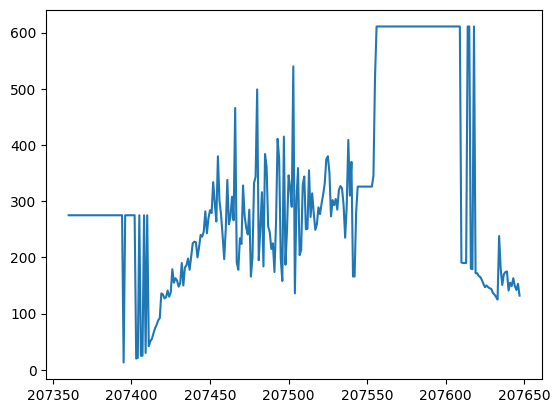

In [ ]:
plt.plot(flow_node_df_cpt[flow_node_df_cpt['Node_ID']==id_set[0]]['TotalFlow'].iloc[:288])

# Generate Samples

In [ ]:
tim_gap = 5 * 60
seq_len = n_days * 288
t_min = flow_node_df_cpt['Timestamp'].min() 
t_max = flow_node_df_cpt['Timestamp'].max()
samples = np.zeros([seq_len,len(id_set),3])
smo_flg = 1

In [ ]:
rel_err = []
for i in tqdm(range(len(id_set)),desc='Proceeding...',ncols=100):
  temp = flow_node_df_cpt[flow_node_df_cpt['Node_ID'] == id_set[i]].sort_values(by = 'Timestamp')
  if smo_flg == 1:
    tmp_err = []
    for k in ['TotalFlow','AvgOccupancy','AvgSpeed']:
      tmp = temp[k]
      temp[k] = scipy.signal.savgol_filter(temp[k], 50, 3, mode= 'nearest')
      tmp_err.append((abs(tmp-temp[k])/tmp).fillna(value=0).replace(np.inf,0).mean())
    rel_err.append(tmp_err)
  samples[:,i,:] = np.array(temp[['TotalFlow','AvgOccupancy','AvgSpeed']])

Proceeding...: 100%|████████████████████████████████████████████████| 93/93 [00:01<00:00, 75.42it/s]


In [ ]:
for i in range(3):
  print(100*np.mean([j[i] for j in rel_err]))

6.471115463588766
8.273472454928035
2.038883160019052


In [ ]:
#samples
#save
#np.save('/content/gdrive/MyDrive/Data/TrafficFlow/Macro_Data/Generated/samples.npy',samples) 
#np.save('/content/gdrive/MyDrive/Data/TrafficFlow/Macro_Data/rel_err.npy',np.array(rel_err)) 
#load
samples = np.load('/content/gdrive/MyDrive/Data/TrafficFlow/Macro_Data/Generated/samples.npy')


In [ ]:
#samples_modified
#save
#np.save('/content/gdrive/MyDrive/Data/TrafficFlow/Macro_Data/Generated/samples_modified.npy',samples) 
#np.save('/content/gdrive/MyDrive/Data/TrafficFlow/Macro_Data/rel_err.npy',np.array(rel_err)) 
#load
samples_modified = np.load('/content/gdrive/MyDrive/Data/TrafficFlow/Macro_Data/Generated/samples_modified.npy')

In [ ]:
samples.shape

(8640, 93, 3)

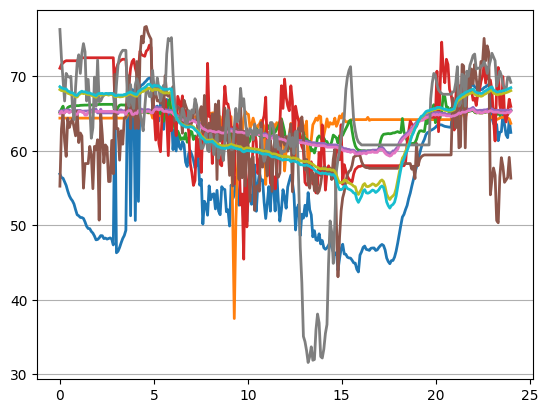

In [ ]:
for i in range(20,30):
  plt.plot(np.linspace(0,24,288),samples[:288,i,2],linewidth= 2)
plt.grid(which='major', axis='y')

In [ ]:
samples_modified.shape

(8640, 93, 3)

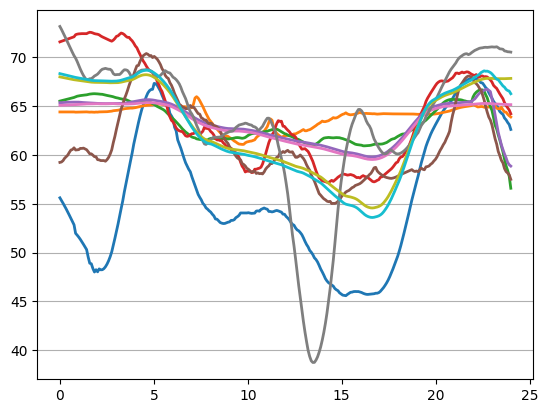

In [ ]:
for i in range(20,30):
  plt.plot(np.linspace(0,24,288),samples_modified[:288,i,2],linewidth= 2)
plt.grid(which='major', axis='y')